# Motion Analysis and Tracking

This notebook shows a demonstration of optical flow to determine motion between frames of a video, and tracking of points of interest across a video.

References:

- https://docs.opencv.org/4.x/d4/dee/tutorial_optical_flow.html
- https://docs.opencv.org/4.x/db/d27/tutorial_py_table_of_contents_feature2d.html
- Video sequence: https://www.bogotobogo.com/python/OpenCV_Python/images/mean_shift_tracking/slow_traffic_small.mp4

Import packages

In [23]:
import numpy as np
import cv2 as cv


In [24]:
# Import package if using OpenCV's imshow function in Google Colab

google_colab = False
if google_colab:
  from google.colab.patches import cv2_imshow

Open video file

In [25]:
# Set the path to the video
video_path = 'Data/slow_traffic_small.mp4'

In [26]:
cap = cv.VideoCapture(video_path)


Read video and store frames. Also, convert the frames to grayscale, and store them too.

In [27]:
frame_gray_all = []
frame_all = []

while(1):
  ret, frame = cap.read()
  if not ret:
      print('No frames grabbed!')
      break

  frame_all.append(frame)

  # Convert to grayscale
  frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
  frame_gray_all.append(frame_gray)

  k = cv.waitKey(30) & 0xff
  if k == 27:
      break

No frames grabbed!


# Optical Flow

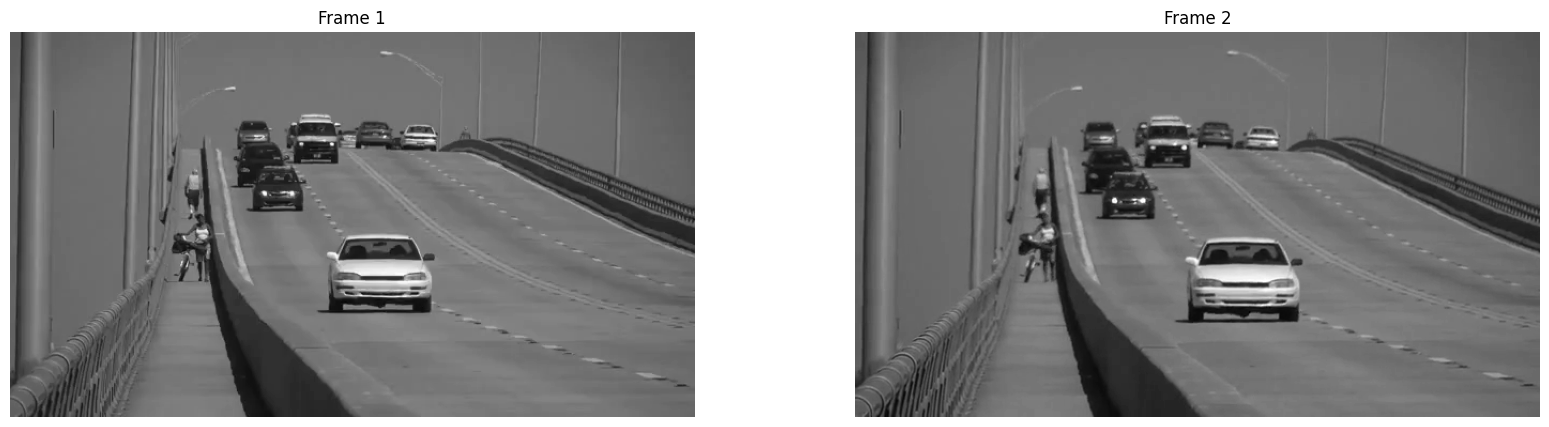

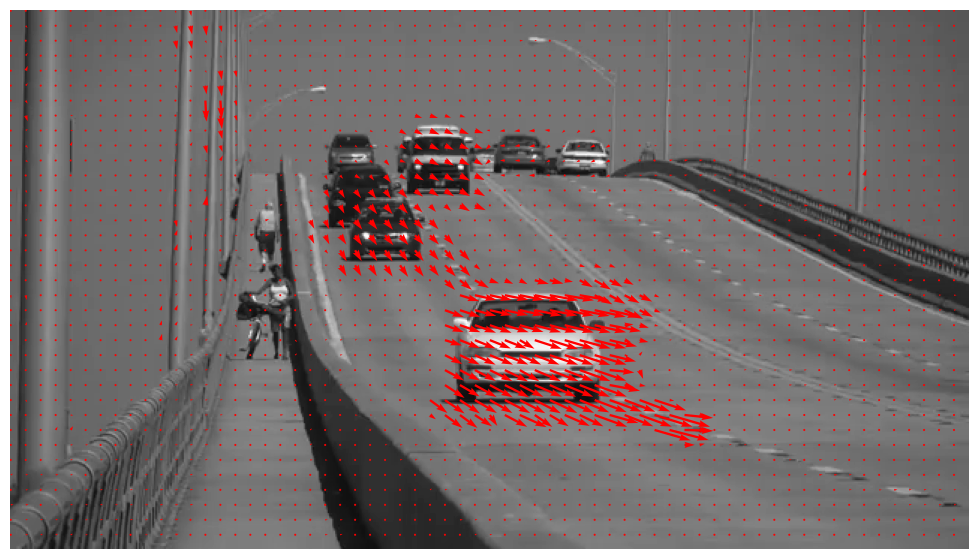

In [28]:
from matplotlib import pyplot as plt

# Get the first frame, and 20th frame (grayscale versions)
old_gray = frame_gray_all[0]
frame_gray = frame_gray_all[20]

# Compute the optical flow between the two frames
flow = cv.calcOpticalFlowFarneback(np.array(old_gray),
                                   np.array(frame_gray),
                                   flow=None,
                                   pyr_scale=0.5,
                                   levels=3,
                                   winsize=15,
                                   iterations=3,
                                   poly_n=5,
                                   poly_sigma=1.2,
                                   flags=0)

# Set the step size to control spacing in the flow plot
step = 10

# Get the height and width of the frame
H, W = old_gray.shape

# Create meshgrid for x and y coordinates
X, Y = np.meshgrid(np.arange(0, W, step), np.arange(0, H, step))

# Extract the flow vectors for the sampled points
flow_x = flow[::step, ::step, 0]
flow_y = flow[::step, ::step, 1]

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title('Frame 1')
plt.imshow(old_gray, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.title('Frame 2')
plt.imshow(frame_gray, cmap='gray')
plt.axis('off')

# Display the quiver plot
plt.figure(figsize=(28, 7))
plt.quiver(X, Y, flow_x, flow_y, color='r', angles='xy', scale_units='xy', scale=1)
plt.imshow(old_gray, cmap='gray')
plt.axis('off')
plt.show()

# Tracking

## Tracking using Harris Corner Detection

### Find the Harris features in the first frame

Find the features and show them on the image

In [29]:
# Open file
cap = cv.VideoCapture(video_path)


In [30]:
# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)

dst = cv.cornerHarris(old_gray, blockSize=2, ksize=3, k=0.04)

# Result is dilated for marking the corners (not important)
dst = cv.dilate(dst, None)

# Threshold for an optimal value, it may vary depending on the image.
old_frame = frame_all[0].copy()
old_frame[dst > 0.01*dst.max()]=[0, 0, 255]

if google_colab:
  cv2_imshow(old_frame)
else:
  cv.imshow('frame', old_frame)
  # Wait for the escape key to be pressed
  cv.waitKey(0) & 0xFF
  cv.destroyAllWindows()

Find the centroid coordinates

In [31]:
# Find points having an intensity satisfying a threshold (the corners)
ret, dst = cv.threshold(dst, 0.01*dst.max(), 255, 0) # Image, threshold, max, value assigned to pixels below the threshold (and the thresholding type) ('0' means we're using cv.THRESH_BINARY)
dst = np.uint8(dst)

# Find centroids
ret, labels, stats, centroids = cv.connectedComponentsWithStats(dst)
centroids = np.expand_dims(centroids, 1)
centroids = centroids.astype('float32')
centroids

array([[[319.9434  , 179.76097 ]],

       [[347.4     ,  19.4     ]],

       [[356.5     ,  20.      ]],

       [[209.66667 ,  52.833332]],

       [[202.      ,  53.      ]],

       [[298.      ,  79.      ]],

       [[267.23215 ,  85.83929 ]],

       [[304.03333 ,  85.86667 ]],

       [[226.      ,  86.5     ]],

       [[369.74603 ,  93.111115]],

       [[393.      ,  89.5     ]],

       [[242.      ,  91.      ]],

       [[308.5     ,  93.      ]],

       [[349.72726 ,  96.41818 ]],

       [[396.72528 ,  99.61539 ]],

       [[232.51352 ,  98.567566]],

       [[263.      ,  97.5     ]],

       [[311.17142 ,  99.85714 ]],

       [[322.41177 ,  99.79412 ]],

       [[271.67163 , 103.37313 ]],

       [[370.3846  , 101.80769 ]],

       [[299.57352 , 103.838234]],

       [[379.8421  , 103.89474 ]],

       [[387.66666 , 103.833336]],

       [[326.70908 , 107.65455 ]],

       [[260.5     , 108.      ]],

       [[351.      , 108.5     ]],

       [[214.      , 109.   

### Track the Harris featurs across the video

Define parameters for the Lucas-Kanade optical flow algorithm

In [32]:
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

Define some additional parameters for plotting/drawing

In [33]:
# Create some random colors (to use for plotting)
color2 = np.random.randint(0, 255, (110, 3))

In [34]:
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

Track the features across each frame

In [35]:
# Open file
cap = cv.VideoCapture(video_path)


In [36]:
while(1):
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break

    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # Calculate optical flow using the iterative Lucas-Kanade method with pyramids (cv.calcOpticalFlowPyrLK)
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, centroids, None, **lk_params)

    # Select good points, using st
    if p1 is not None:
        good_new = p1[st==1]
        good_old = centroids[st==1]

    # Draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), color2[i].tolist(), 2) # Plot the line from previous point location to new point location
        frame = cv.circle(frame, (int(a), int(b)), 5, color2[i].tolist(), -1) # Plot a circle at the new location
    img = cv.add(frame, mask) # Superimpose mask (with lines and point circles) on image

    if google_colab:
      cv2_imshow(img)
    else:
      cv.imshow('frame', img)

    k = cv.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    centroids = good_new.reshape(-1, 1, 2)

cv.destroyAllWindows()

## Tracking using ShiTomasi corner detection

J. Shi and C. Tomasi made a small modification to the Harris Corner detector in their paper **Good Features to Track** which shows better results compared to Harris Corner Detector. The scoring function in Harris Corner Detector was given by:

$R = \lambda_1 \lambda_2 - k(\lambda_1+\lambda_2)^2$

Instead of this function, Shi-Tomasi proposed:
$R = \min(\lambda_1, \lambda_2)$

If it is a greater than a threshold value, it is considered as a corner.

If we plot it in $\lambda_1 - \lambda_2$ space as we did in Harris Corner Detector, we get an image as below:

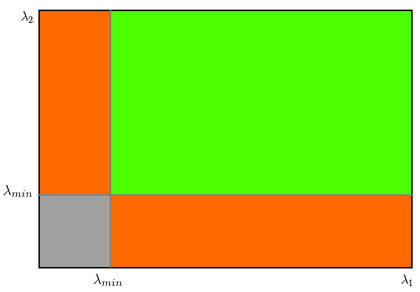

From the figure, you can see that only when $\lambda_1$ and $\lambda_2$ are above a minimum value, $\lambda_{\min}$, it is considered as a corner (green region).

Source: https://docs.opencv.org/4.x/d4/d8c/tutorial_py_shi_tomasi.html

Define parameters for ShiTomasi corner detection

In [37]:
# Parameters for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7)


Find corners in first frame

In [38]:
# Open file
cap = cv.VideoCapture(video_path)


In [39]:
# Take first frame and find corners in it
ret, old_frame = cap.read()

# Convert to grayscale
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)

# Use the ShiTomasi methods to get the corners (cv.goodFeaturesToTrack)
p0 = cv.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

Define parameters for the Lucas-Kanade optical flow algorithm

In [40]:
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))


Define some additional parameters for plotting/drawing

In [41]:
# Create some random colors (to use for plotting)
color = np.random.randint(0, 255, (100, 3))


In [42]:
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)


Track the features across each frame

In [43]:
while(1):
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break

    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # Calculate optical flow using the iterative Lucas-Kanade method with pyramids (cv.calcOpticalFlowPyrLK)
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, centroids, None, **lk_params)

    # Select good points, using st
    if p1 is not None:
        good_new = p1[st==1]
        good_old = centroids[st==1]

    # Draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), color2[i].tolist(), 2) # Plot the line from previous point location to new point location
        frame = cv.circle(frame, (int(a), int(b)), 5, color2[i].tolist(), -1) # Plot a circle at the new location
    img = cv.add(frame, mask) # Superimpose mask (with lines and point circles) on image

    if google_colab:
      cv2_imshow(img)
    else:
      cv.imshow('frame', img)

    k = cv.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    centroids = good_new.reshape(-1, 1, 2)

cv.destroyAllWindows()